# Installations

In [1]:
!pip install opencv-contrib-python
!pip install numpy==1.23.5 scipy==1.10.0 open3d==0.16.0
!pip install ultralytics==8.0.28

# Import statements

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pickle
import open3d as o3d
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Global variables

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define the path to your stereo images
stereo_images_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Stereo images'

# Filenames of the stereo images
filenames = [
    'SideA_LeftCam.jpg', 'SideA_RightCam.jpg',
    'SideB_LeftCam.jpg', 'SideB_RightCam.jpg',
    'SideC_LeftCam.jpg', 'SideC_RightCam.jpg',
    'SideD_LeftCam.jpg', 'SideD_RightCam.jpg'
]

# Define the path to your calibration images
calibration_images_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Checkerboard/Large checkerboard/Version 2/Original'

# Filenames of the calibration images (14 stereo pairs)
calibration_filenames = [
    'Calibration_A_LC.jpg', 'Calibration_A_RC.jpg',
    'Calibration_B_LC.jpg', 'Calibration_B_RC.jpg',
    'Calibration_C_LC.jpg', 'Calibration_C_RC.jpg',
    'Calibration_D_LC.jpg', 'Calibration_D_RC.jpg',
    'Calibration_E_LC.jpg', 'Calibration_E_RC.jpg',
    'Calibration_F_LC.jpg', 'Calibration_F_RC.jpg',
    'Calibration_G_LC.jpg', 'Calibration_G_RC.jpg',
    'Calibration_H_LC.jpg', 'Calibration_H_RC.jpg',
    'Calibration_I_LC.jpg', 'Calibration_I_RC.jpg',
    'Calibration_J_LC.jpg', 'Calibration_J_RC.jpg',
    'Calibration_K_LC.jpg', 'Calibration_K_RC.jpg',
    'Calibration_L_LC.jpg', 'Calibration_L_RC.jpg',
    'Calibration_M_LC.jpg', 'Calibration_M_RC.jpg',
    'Calibration_N_LC.jpg', 'Calibration_N_RC.jpg'
]

# Save calibration data in XML format
calibration_data_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Preliminaries/calibration_data.xml'

# Define the path of YOLOv8 model
model_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/YOLOv8 model/best.pt'
model = YOLO(model_path)

# Define the path to save segmented images
segmented_images_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Segmented plants'

# Define the path to save depth maps
depth_maps_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Depth maps'

# Define the path to save point clouds
point_clouds_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Point clouds'

# Define the path to save the merged point cloud
merged_pc_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Single point cloud'

# Define the path to save the meshed model
meshed_model_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Meshed point cloud'

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu')  # load


In [5]:
# Define the scaling percentage for resizing images
scale_percent = 25  # Adjust as needed (e.g., 25%, 50%)

# Functions

## Preliminaries

In [6]:
# Define a function to resize images (if needed)
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    return resized_image

In [7]:
# Display the images
def display_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(2, 4, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Camera Calibration, and Image Rectification

## Image Segmentation

In [8]:
# Define the segment_plant function
def segment_plant(image, filename):
    # Predict using the model
    results = model.predict(source=image, conf=0.70, save=False, verbose=False)

    # Check if any objects were detected
    if len(results[0].boxes) == 0:
        print(f"No plant detected in image {filename}. Returning original image.")
        return image, np.ones(image.shape[:2], dtype=bool)  # Return original image and a mask of ones

    # Initialize a background image (black)
    background = np.zeros_like(image)

    # Combine masks for all detected objects
    combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)
    for mask_data in results[0].masks.data:
        mask = mask_data.cpu().numpy()
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
        combined_mask = np.logical_or(combined_mask, mask)

    # Apply the combined mask to extract the plant(s)
    segmented_image = np.where(combined_mask[..., None], image, background)

    return segmented_image, combined_mask

## Depth Map Generation

## Point Cloud Generation

## Point Cloud Registration

## Mesh Generation

# Program start

## Preliminaries

### Retrieve stereo images

In [9]:
# Load and resize the images
stereo_images = []
for filename in filenames:
    image_path = os.path.join(stereo_images_path, filename)
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        # Resize the image
        img_resized = resize_image(img, scale_percent)
        stereo_images.append(img_resized)
    else:
        print(f"Error: {filename} not found at {image_path}")

### Display stereo images

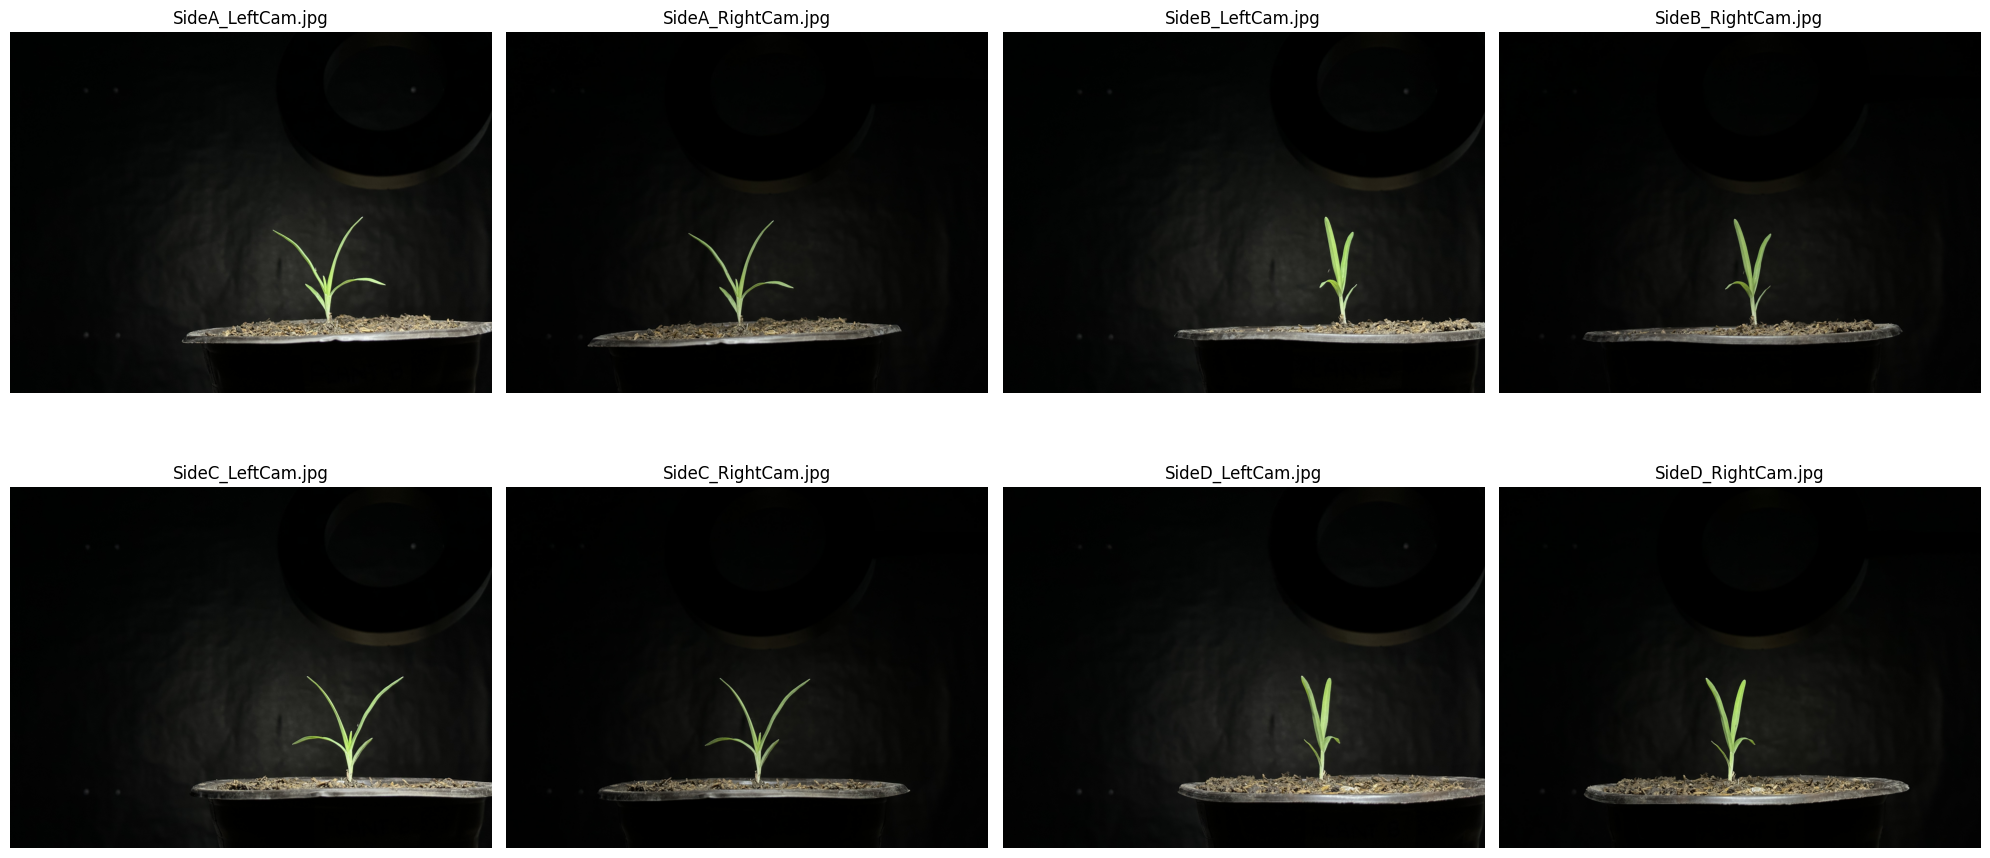

In [10]:
titles = filenames
display_images(stereo_images, titles)

## Camera Calibration, and Image Rectification

Skipping calibration image pair 1 due to detection failure.
Skipping calibration image pair 2 due to detection failure.
Skipping calibration image pair 3 due to detection failure.


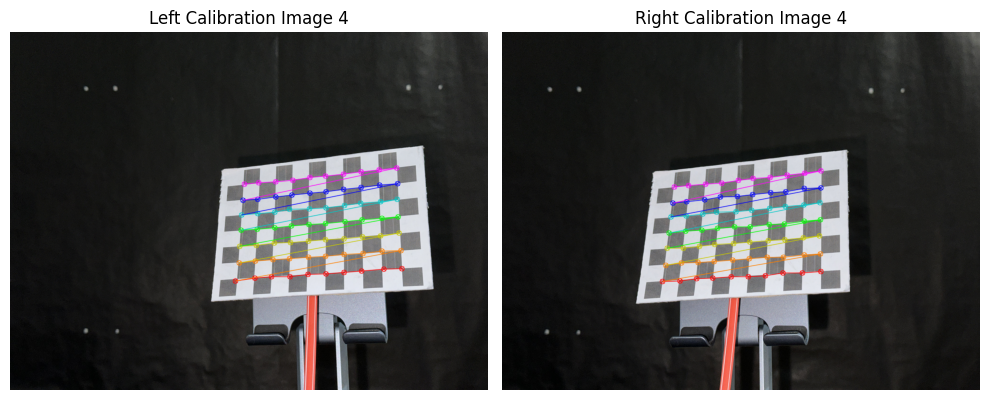

Skipping calibration image pair 5 due to detection failure.


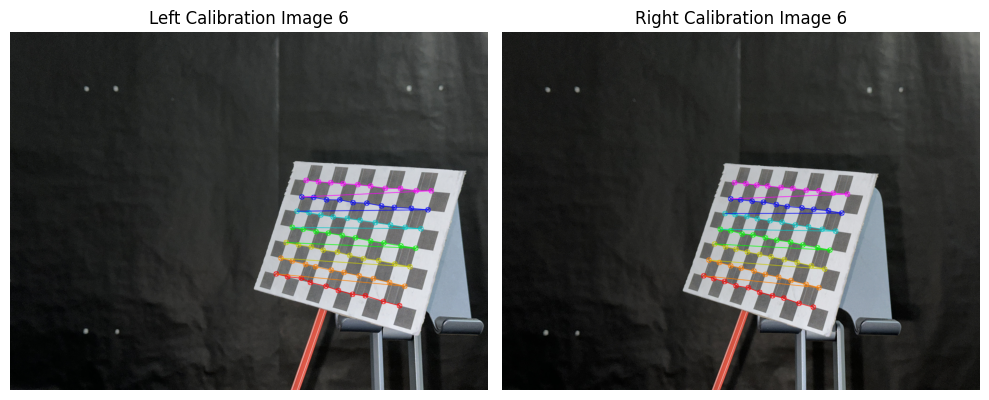

Skipping calibration image pair 7 due to detection failure.
Skipping calibration image pair 8 due to detection failure.


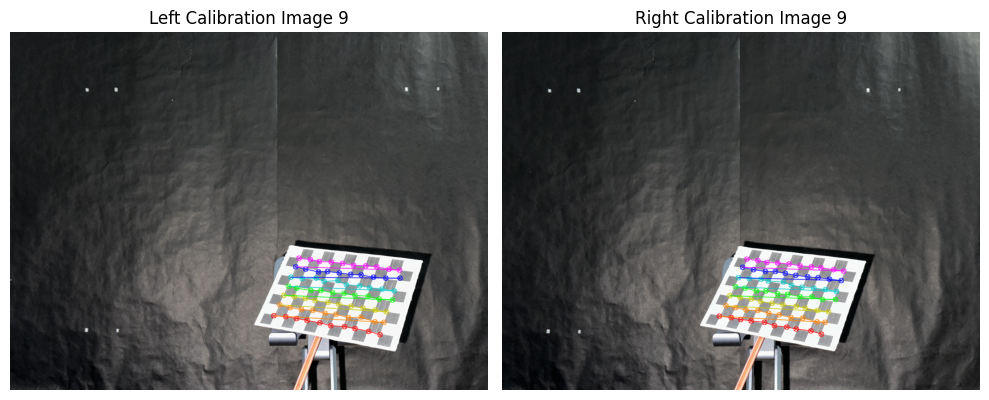

Skipping calibration image pair 10 due to detection failure.


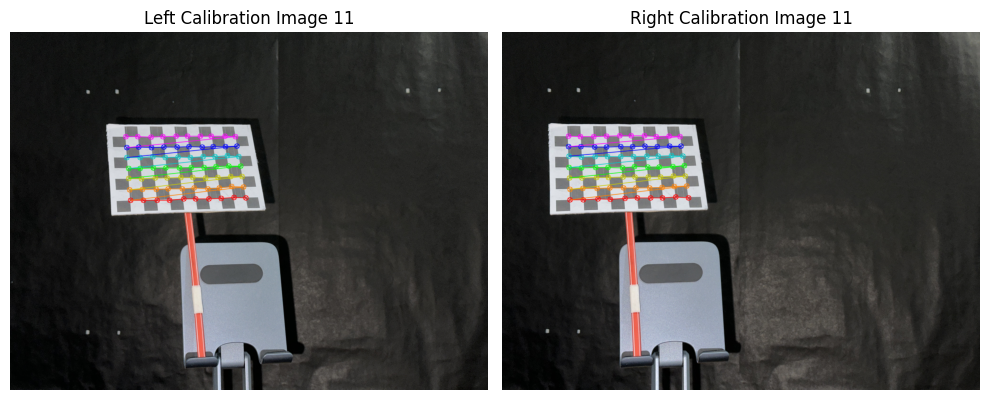

Skipping calibration image pair 12 due to detection failure.
Skipping calibration image pair 13 due to detection failure.
Skipping calibration image pair 14 due to detection failure.
Number of valid calibration pairs: 4
Calibration data saved to /content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Preliminaries/calibration_data.xml


In [11]:
# Load and preprocess calibration images
left_calib_images = []
right_calib_images = []
for i in range(0, len(calibration_filenames), 2):
    left_img_path = os.path.join(calibration_images_path, calibration_filenames[i])
    right_img_path = os.path.join(calibration_images_path, calibration_filenames[i+1])
    if os.path.exists(left_img_path) and os.path.exists(right_img_path):
        # Load images
        left_img = cv2.imread(left_img_path)
        right_img = cv2.imread(right_img_path)

        # Preprocessing Steps
        # 1. Resize images to reduce computational load and improve corner detection
        left_img_resized = resize_image(left_img, scale_percent)
        right_img_resized = resize_image(right_img, scale_percent)

        # 2. Convert images to grayscale
        gray_left = cv2.cvtColor(left_img_resized, cv2.COLOR_BGR2GRAY)
        gray_right = cv2.cvtColor(right_img_resized, cv2.COLOR_BGR2GRAY)

        # 3. Apply Gaussian Blur to reduce noise
        gray_left_blur = cv2.GaussianBlur(gray_left, (5, 5), 0)
        gray_right_blur = cv2.GaussianBlur(gray_right, (5, 5), 0)

        # 4. Apply adaptive thresholding to enhance the checkerboard pattern
        gray_left_thresh = cv2.adaptiveThreshold(gray_left_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        gray_right_thresh = cv2.adaptiveThreshold(gray_right_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

        # Store preprocessed images
        left_calib_images.append((left_img_resized, gray_left_thresh))
        right_calib_images.append((right_img_resized, gray_right_thresh))
    else:
        print(f"Error: Calibration images {calibration_filenames[i]} or {calibration_filenames[i+1]} not found.")

# Camera calibration parameters
checkerboard_size = (10, 7)  # Internal corners per chessboard row and column
square_size = 12.5  # Size of a square in your defined unit (cm)

# Prepare object points
objp = np.zeros((checkerboard_size[0]*checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
objp *= square_size

# Arrays to store object points and image points
objpoints = []        # 3d point in real world space
imgpoints_left = []   # 2d points in image plane.
imgpoints_right = []

# Termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

valid_pairs = 0  # Counter for valid calibration pairs

# Find chessboard corners and calibrate
for idx, ((left_img, gray_left), (right_img, gray_right)) in enumerate(zip(left_calib_images, right_calib_images)):
    # Find chessboard corners
    ret_left, corners_left = cv2.findChessboardCorners(gray_left, checkerboard_size, None)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, checkerboard_size, None)

    if ret_left and ret_right:
        objpoints.append(objp)

        # Refine corner locations
        corners_left = cv2.cornerSubPix(gray_left, corners_left, (11,11), (-1,-1), criteria)
        corners_right = cv2.cornerSubPix(gray_right, corners_right, (11,11), (-1,-1), criteria)

        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)
        valid_pairs += 1

        # Optional: Draw and display the corners
        cv2.drawChessboardCorners(left_img, checkerboard_size, corners_left, ret_left)
        cv2.drawChessboardCorners(right_img, checkerboard_size, corners_right, ret_right)

        # Display the images with detected corners
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        axs[0].set_title(f'Left Calibration Image {idx+1}')
        axs[0].axis('off')

        axs[1].imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f'Right Calibration Image {idx+1}')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping calibration image pair {idx+1} due to detection failure.")

# Check if sufficient valid pairs were found
if valid_pairs < 2:
    print("Error: Not enough valid calibration images for stereo calibration.")
else:
    print(f"Number of valid calibration pairs: {valid_pairs}")

    # Stereo calibration
    ret, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(
        objpoints,
        imgpoints_left,
        imgpoints_right,
        None, None, None, None,
        gray_left.shape[::-1],
        criteria=criteria,
        flags=cv2.CALIB_FIX_INTRINSIC
    )

    # Stereo rectification
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1, distCoeffs1,
        cameraMatrix2, distCoeffs2,
        gray_left.shape[::-1], R, T
    )

    # Create a FileStorage object
    fs = cv2.FileStorage(calibration_data_path, cv2.FILE_STORAGE_WRITE)

    # Write data
    fs.write("cameraMatrix1", cameraMatrix1)
    fs.write("distCoeffs1", distCoeffs1)
    fs.write("cameraMatrix2", cameraMatrix2)
    fs.write("distCoeffs2", distCoeffs2)
    fs.write("R", R)
    fs.write("T", T)
    fs.write("R1", R1)
    fs.write("R2", R2)
    fs.write("P1", P1)
    fs.write("P2", P2)
    fs.write("Q", Q)

    # Release the FileStorage object
    fs.release()
    print(f"Calibration data saved to {calibration_data_path}")

## Image Segmentation, and Segmentation Mask Generation

### Segment plant objects

In [12]:
# Segment the images
segmented_images = []
segmentation_masks = []
for img, filename in zip(stereo_images, filenames):
    segmented_img, mask = segment_plant(img, filename)
    segmented_images.append(segmented_img)
    segmentation_masks.append(mask)

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU
YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients, 42.4 GFLOPs


### Save segmented images

In [13]:
# Create directory if it doesn't exist
os.makedirs(segmented_images_path, exist_ok=True)

# Save the segmented images
for i, img in enumerate(segmented_images):
    save_path = os.path.join(segmented_images_path, f'Segmented_{filenames[i]}')
    cv2.imwrite(save_path, img)

### Display segmented images

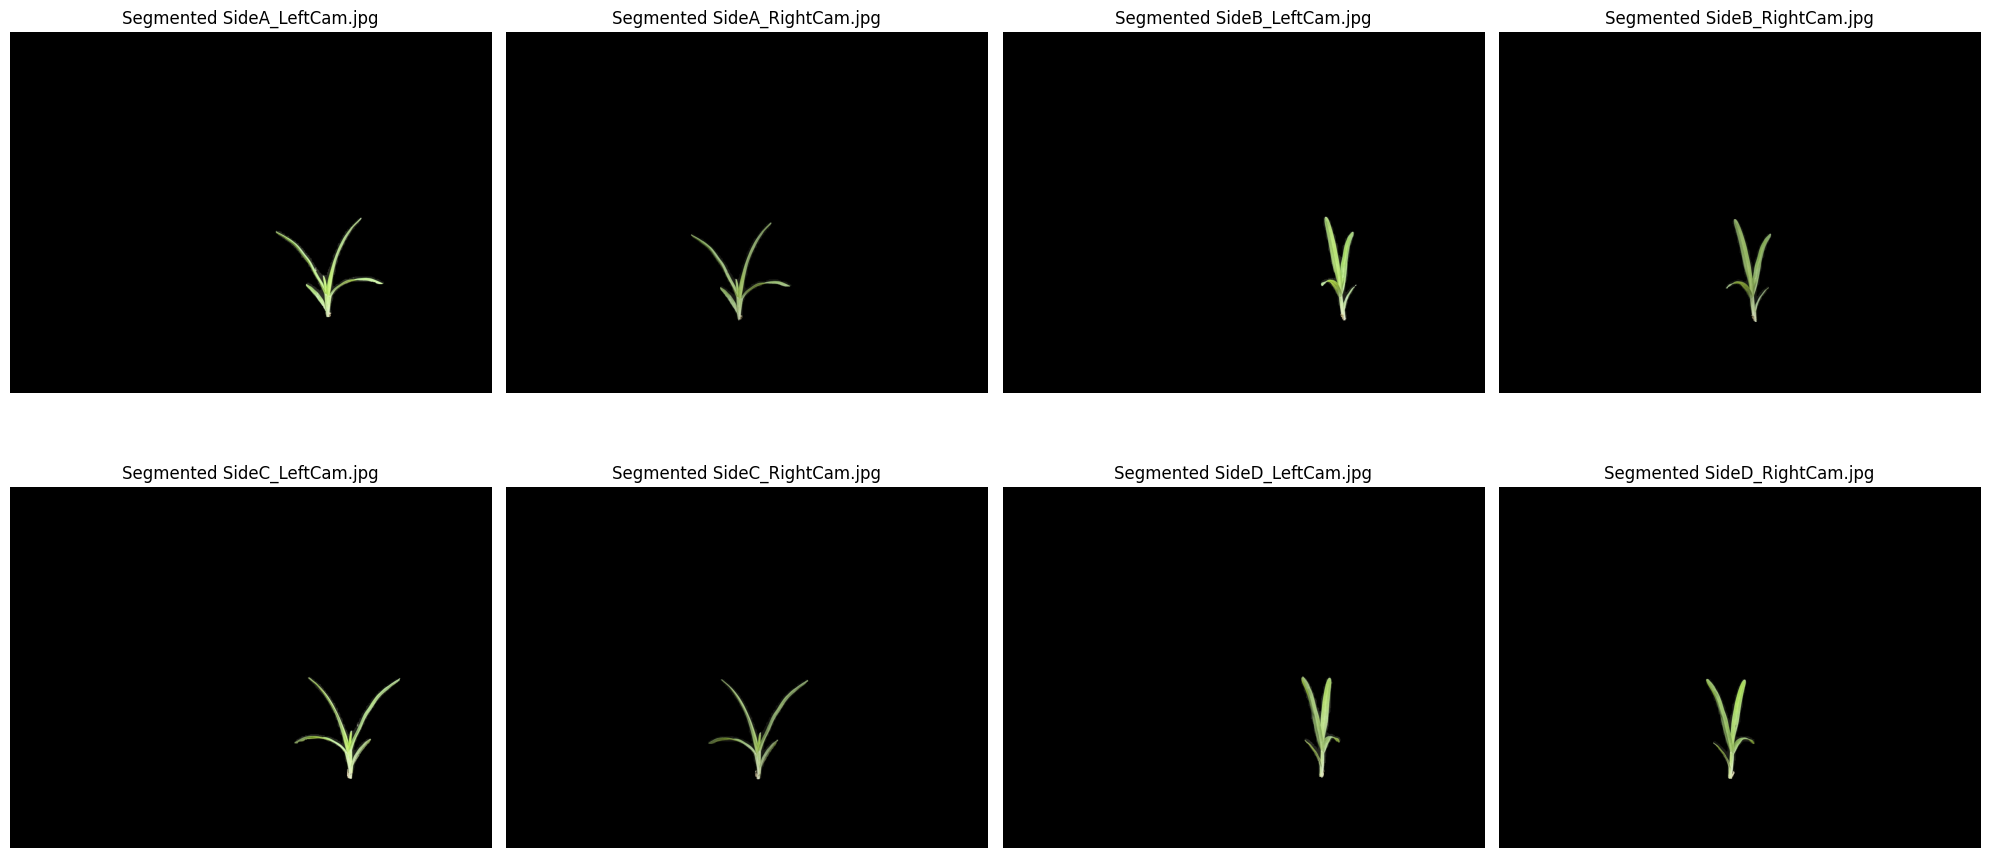

In [14]:
# Display the segmented images
display_images(segmented_images, [f'Segmented {title}' for title in titles])

## Depth Map Generation

### Generate depth maps

In [15]:
fs = cv2.FileStorage(calibration_data_path, cv2.FILE_STORAGE_READ)

cameraMatrix1 = fs.getNode("cameraMatrix1").mat()
distCoeffs1 = fs.getNode("distCoeffs1").mat()
cameraMatrix2 = fs.getNode("cameraMatrix2").mat()
distCoeffs2 = fs.getNode("distCoeffs2").mat()
R = fs.getNode("R").mat()
T = fs.getNode("T").mat()
R1 = fs.getNode("R1").mat()
R2 = fs.getNode("R2").mat()
P1 = fs.getNode("P1").mat()
P2 = fs.getNode("P2").mat()
Q = fs.getNode("Q").mat()

fs.release()

# Initialize StereoSGBM matcher with adjusted parameters
image_height, image_width = segmented_images[0].shape[:2]
num_disparities = ((image_width // 8) + 15) & -16  # Ensure it's divisible by 16
block_size = 5  # Adjust as needed

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=num_disparities,
    blockSize=block_size,
    P1=8 * 3 * block_size ** 2,
    P2=32 * 3 * block_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

# Compute rectification maps (optional but recommended)
map1_left, map2_left = cv2.initUndistortRectifyMap(
    cameraMatrix1, distCoeffs1, R1, P1, (image_width, image_height), cv2.CV_16SC2
)
map1_right, map2_right = cv2.initUndistortRectifyMap(
    cameraMatrix2, distCoeffs2, R2, P2, (image_width, image_height), cv2.CV_16SC2
)

depth_maps = []
for i in range(0, len(stereo_images), 2):
    # Original images
    left_img_orig = stereo_images[i]
    right_img_orig = stereo_images[i+1]

    # Segmentation masks
    left_mask = segmentation_masks[i]      # Assuming you have the masks stored
    right_mask = segmentation_masks[i+1]

    # Apply rectification maps to original images
    left_img_rect = cv2.remap(left_img_orig, map1_left, map2_left, cv2.INTER_LINEAR)
    right_img_rect = cv2.remap(right_img_orig, map1_right, map2_right, cv2.INTER_LINEAR)

    # Convert to grayscale
    gray_left = cv2.cvtColor(left_img_rect, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_img_rect, cv2.COLOR_BGR2GRAY)

    # Compute disparity map
    disparity_map = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0

    # Apply the segmentation mask to the disparity map
    left_mask_rect = cv2.remap(left_mask.astype(np.uint8), map1_left, map2_left, cv2.INTER_LINEAR).astype(bool)
    right_mask_rect = cv2.remap(right_mask.astype(np.uint8), map1_right, map2_right, cv2.INTER_LINEAR).astype(bool)

    combined_mask = left_mask_rect & right_mask_rect
    disparity_map_masked = np.where(combined_mask, disparity_map, 0)

    depth_maps.append(disparity_map_masked)

### Save depth maps

In [16]:
# Create directory if it doesn't exist
os.makedirs(depth_maps_path, exist_ok=True)

# Save the depth maps
for i, depth_map in enumerate(depth_maps):
    save_path = os.path.join(depth_maps_path, f'DepthMap_{i+1}.png')
    # Normalize the disparity map for visualization
    norm_depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(save_path, norm_depth_map.astype(np.uint8))

### Display depth maps

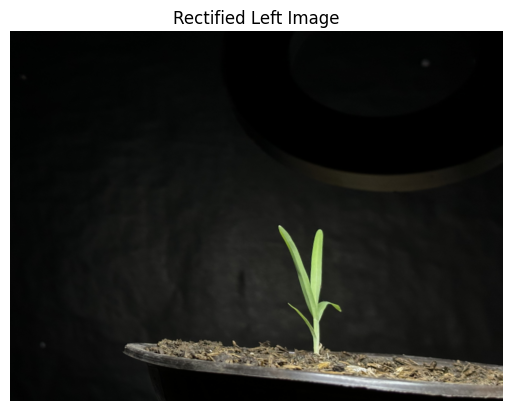

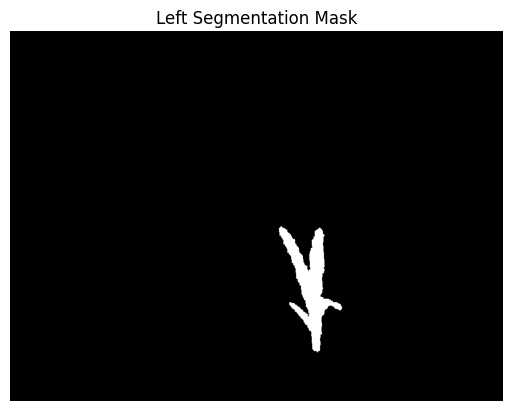

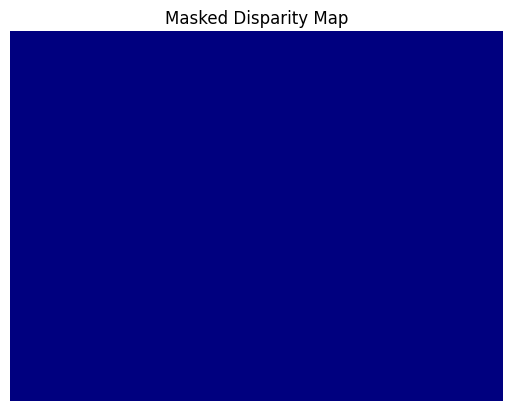

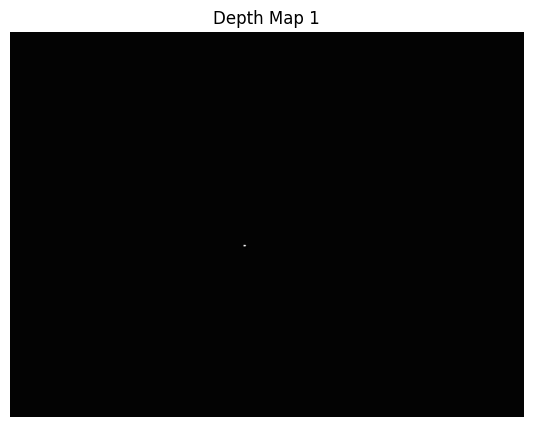

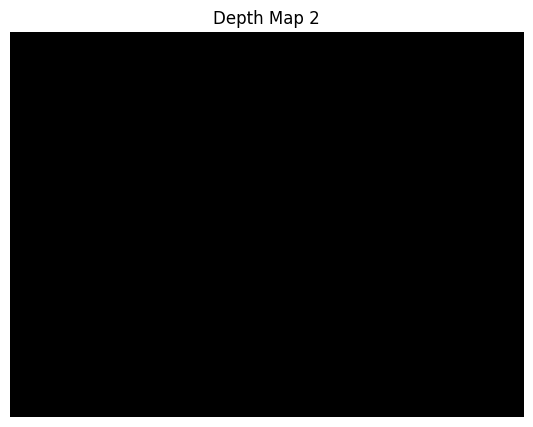

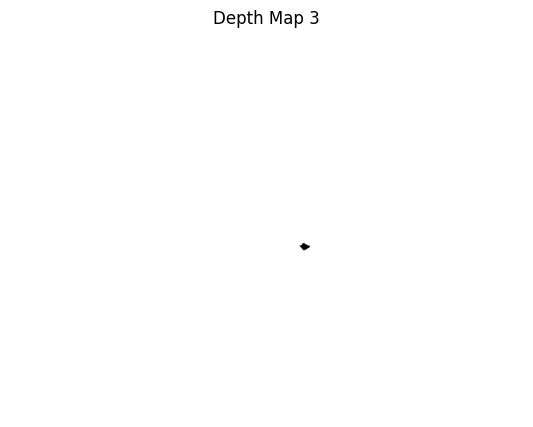

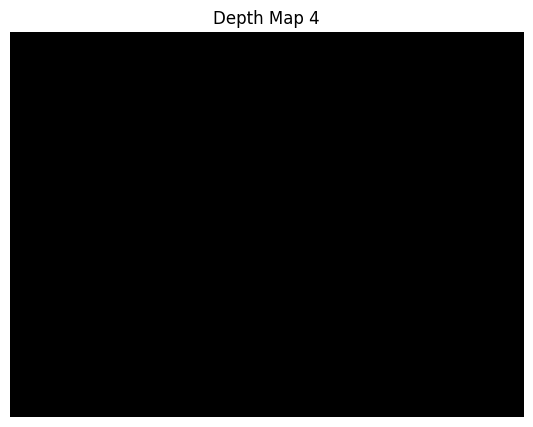

In [17]:
# Display rectified left image
plt.imshow(cv2.cvtColor(left_img_rect, cv2.COLOR_BGR2RGB))
plt.title('Rectified Left Image')
plt.axis('off')
plt.show()

# Display left mask
plt.imshow(left_mask_rect, cmap='gray')
plt.title('Left Segmentation Mask')
plt.axis('off')
plt.show()

# Display masked disparity map
plt.imshow(disparity_map_masked, cmap='jet')
plt.title('Masked Disparity Map')
plt.axis('off')
plt.show()

# Display the depth maps
for i, depth_map in enumerate(depth_maps):
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_map, 'gray')
    plt.title(f'Depth Map {i+1}')
    plt.axis('off')
    plt.show()

## Point Cloud Generation

### Generate point clouds

In [ ]:
point_clouds = []
for idx, depth_map in enumerate(depth_maps):
    # Get corresponding left image for colors
    color_image = segmented_images[idx*2]

    # Reproject to 3D
    points_3D = cv2.reprojectImageTo3D(depth_map, Q)
    mask = depth_map > depth_map.min()

    # Apply mask to points and colors
    points = points_3D[mask]
    colors = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    colors = colors[mask]

    # Create Open3D point cloud
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(points)
    pc.colors = o3d.utility.Vector3dVector(colors / 255.0)
    point_clouds.append(pc)

### Save point clouds

In [ ]:
# Create directory if it doesn't exist
os.makedirs(point_clouds_path, exist_ok=True)

# Save the point clouds
for i, pc in enumerate(point_clouds):
    save_path = os.path.join(point_clouds_path, f'PointCloud_{i+1}.ply')
    o3d.io.write_point_cloud(save_path, pc)

### Display point clouds

In [ ]:
# Display the point clouds
for i, pc in enumerate(point_clouds):
    print(f'Displaying Point Cloud {i+1}')
    o3d.visualization.draw_geometries([pc])

## Point Cloud Registration

### Merge point clouds

In [ ]:
# Merge the point clouds using ICP registration
merged_pc = point_clouds[0]
for i in range(1, len(point_clouds)):
    print(f'Registering Point Cloud {i+1} to the merged point cloud')
    threshold = 0.02  # Adjust as needed
    trans_init = np.eye(4)
    reg_p2p = o3d.pipelines.registration.registration_icp(
        point_clouds[i], merged_pc, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )
    print(f'Transformation Matrix for Point Cloud {i+1}:\n', reg_p2p.transformation)
    point_clouds[i].transform(reg_p2p.transformation)
    merged_pc += point_clouds[i]
    merged_pc = merged_pc.voxel_down_sample(voxel_size=0.005)

### Save merged point cloud

In [ ]:
# Create directory if it doesn't exist
os.makedirs(merged_pc_path, exist_ok=True)

# Save the merged point cloud
save_path = os.path.join(merged_pc_path, 'MergedPointCloud.ply')
o3d.io.write_point_cloud(save_path, merged_pc)

### Display merged point cloud

In [ ]:
# Display the merged point cloud
print("Displaying the merged point cloud")
o3d.visualization.draw_geometries([merged_pc])

## Mesh Generation

### Generate mesh from merged point cloud

In [ ]:
# Generate mesh using Poisson surface reconstruction
print("Generating mesh from the merged point cloud...")
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug):
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        merged_pc, depth=9
    )

# Remove low-density vertices to clean up the mesh
vertices_to_remove = densities < np.quantile(densities, 0.01)
mesh.remove_vertices_by_mask(vertices_to_remove)

### Save 3D mesh model

In [ ]:
# Create directory if it doesn't exist
os.makedirs(meshed_model_path, exist_ok=True)

# Save the meshed model
save_path = os.path.join(meshed_model_path, 'MeshedModel.ply')
o3d.io.write_triangle_mesh(save_path, mesh)

### Display 3D mesh model

In [ ]:
# Display the meshed model
print("Displaying the meshed model")
o3d.visualization.draw_geometries([mesh])